In [1]:
from __future__ import print_function
from __future__ import division
from keras.utils import plot_model
from keras.models import Sequential, model_from_json
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, LSTM, Embedding, Dropout, GRU
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from lib.pretty_testing import predict_test, class_weights_max, confusion_matrix
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [2]:
top_words = 5000
embedding_vector_length = 32
maxlen = 100
epochs = 25
#classes = ['poteri', 'scadenza', 'assemblea', 'clausola', 'non_riconducibile']
classes = ['poteri', 'assemblea', 'clausola', 'non_riconducibile']

In [3]:
# load prepared data
with open('../extraction/dataset.p') as f:
    data, labels = pickle.load(f)

In [4]:
padded_data = sequence.pad_sequences(data, maxlen, padding="pre", truncating="post", value=0, dtype='uint32')
labels = np.array(labels)

In [5]:
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=maxlen, mask_zero=True))
model.add(LSTM(32, dropout=0.2)) #return_sequences=True
model.add(Dense(len(classes), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 168,452
Trainable params: 168,452
Non-trainable params: 0
_________________________________________________________________


In [6]:
#plot_model(model, to_file='model.png')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(padded_data, labels, train_size=0.8, stratify=labels)
y_train_cat = to_categorical(y_train, num_classes=len(classes))
y_test_cat = to_categorical(y_test, num_classes=len(classes))

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
[l.get_weights()[0].shape for l in model.layers]

[(5000, 32), (32, 128), (32, 4)]

In [9]:
class_weights = class_weights_max(labels)

In [10]:
class_weights

{0: 6.5042589437819425, 1: 6.616984402079723, 2: 6.537671232876712, 3: 1.0}

In [11]:
h = model.fit(X_train,  y_train_cat, epochs=epochs, batch_size=32, verbose=0, class_weight=class_weights)
#h.history

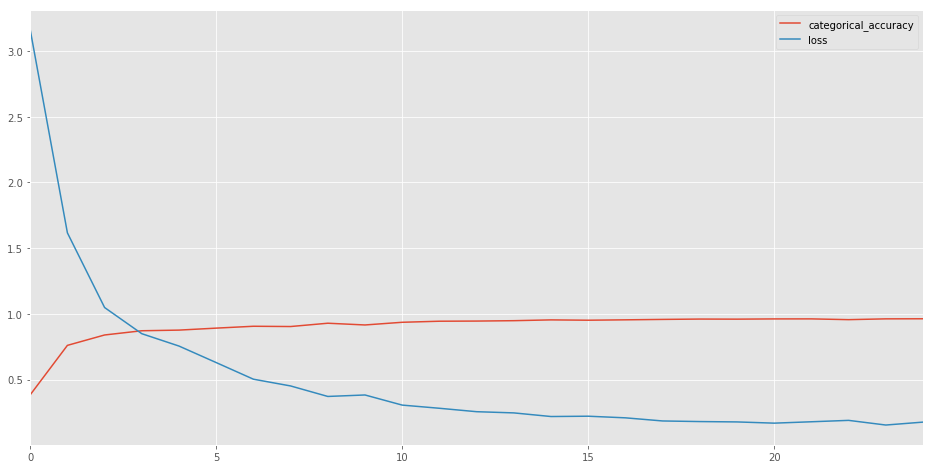

In [12]:
df = pd.DataFrame(h.history)
p = df.plot(figsize=(16,8))

In [13]:
y_pred = predict_test(model, X_test, y_test, classes)

()
Test classification report
Accuracy: 0.839318
             precision    recall  f1-score   support

          0       0.63      0.71      0.67       118
          1       0.79      0.90      0.84       115
          2       0.71      0.78      0.74       117
          3       0.91      0.86      0.88       764

avg / total       0.85      0.84      0.84      1114

Test confusion Matrix
                                 poteri         assemblea          clausola non_riconducibile
               poteri              84.0               4.0               0.0              30.0
            assemblea               1.0             104.0               0.0              10.0
             clausola               0.0               1.0              91.0              25.0
    non_riconducibile              48.0              23.0              37.0             656.0


In [14]:
def post_process_prediction(y_pred, neutral):
    y_post = list(y_pred)
    for i in range(1,len(y_pred)-1):
        y_post[i] = y_post[i+1] if y_post[i] == neutral and y_post[i-1] == y_post[i+1] else y_post[i]
    return y_post
    

In [15]:
y_post = post_process_prediction(y_pred, classes.index('non_riconducibile'))

In [16]:
precision_recall_fscore_support(y_test, y_pred)

(array([ 0.63157895,  0.78787879,  0.7109375 ,  0.90984743]),
 array([ 0.71186441,  0.90434783,  0.77777778,  0.85863874]),
 array([ 0.66932271,  0.84210526,  0.74285714,  0.88350168]),
 array([118, 115, 117, 764]))

In [17]:
confusion_matrix(y_test, y_pred)

array([[ 84,   4,   0,  30],
       [  1, 104,   0,  10],
       [  0,   1,  91,  25],
       [ 48,  23,  37, 656]])

In [18]:
with open('models/extraction_model_30.json','w') as f:
    f.write(model.to_json())

In [19]:
model.save_weights("models/extraction_weights_30.h5")

In [20]:
precision_recall_fscore_support(y_test, y_post)

(array([ 0.58333333,  0.70748299,  0.65942029,  0.91094891]),
 array([ 0.71186441,  0.90434783,  0.77777778,  0.81675393]),
 array([ 0.64122137,  0.79389313,  0.71372549,  0.86128364]),
 array([118, 115, 117, 764]))